# Robust SVM

Support Vector Machines (SVMs) are a set of supervised learning methods primarily used for classification. A robust SVM is a variation of the standard SVM designed to handle data that is noisy or contains outliers more effectively. While the standard SVM focuses on finding a hyperplane that best separates classes by maximizing the margin between them, a robust SVM aims to improve the model’s performance and stability in the presence of noise and outliers.

In this notebook, we consider Example 4.5 introduced in Ali, Kolter, Diamond, and Boyd (2015) [1]. Based on the given data, we formulate the optimization problem as

$$
\begin{array}{ll}
\text{minimize} & \frac{1}{2} \| w \|^2 + C \cdot 1^T \xi \\
\text{subject to} & w^T(x_i + u) + b \geq 1 - \xi _i \\
                  & w^T (x_i + u) + b \geq 1 - \xi_i \\
                  & \xi \geq 0

\end{array}
$$

In [11]:
import numpy as np
import cvxpy as cp
import lropt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

First, we define the data. There are two datasets - both are normally distributed but have different means and variances. Let $N$ denote the number of dimensions in the data.

In [12]:
np.random.seed(1)
N=2
M = 100
C = 0.01 #Regularization Constant
V = 2
rho_values = [1, 10]
P = 2
MU_1 = np.array([0, 0])           # Mean for class 1
SIG_1 = np.array([[1, 0.5],       # Covariance for class 1
                  [0.5, 1]])

MU_2 = np.array([3, 3])           # Mean for class 2
SIG_2 = np.array([[1, -0.7],      # Covariance for class 2
                  [-0.7, 1]])

DATA_1= np.random.multivariate_normal(MU_1, SIG_1, M)
DATA_2= np.random.multivariate_normal(MU_2, SIG_2, M)

Next, we define a function that solves for the SVM probelm. This function checks for an uncertainty set. If it isn't present, the function solves the problem in the deterministic case. We use the ellipsoidal uncertainty set, which can be defined by

$$ \mathcal{U}_{\text{ellips}} = \{  u | \ \| \mathcal{u}\|_2 \le \rho\} $$



In [13]:
def solve_svm(uncertainty_set=None):
    w = cp.Variable(N)
    b = cp.Variable()
    xi = cp.Variable(N, nonneg=True)
    objective = cp.Minimize(1/V * cp.norm2(w)**V + C * (cp.sum(xi)))
    
    constraints = []

    if uncertainty_set:
        u = lropt.UncertainParameter(N, uncertainty_set=uncertainty_set)
    else:
        u = 0
    for i in range(N):
        constraints.append(w@(DATA_1[i] + u) + b >= 1 - xi[i])
        constraints.append(-(w@(DATA_2[i]+ u) + b) >= 1 - xi[i])
        prob = lropt.RobustProblem(objective, constraints)
        
    prob.solve()
    
    return w.value, b.value

Next, we plot the hyperplanes and the uncertainty sets. We define a function to plot the uncertainty set as an ellipse. 

In [14]:
def plot_ellipsoid(ax, center, covariance, rho, color,  alpha=0.3, linewidth=1,):
    vals, vecs = np.linalg.eigh(covariance)
    sort_idx = np.argsort(vals)[::-1]
    vals, vecs = vals[sort_idx], vecs[:, sort_idx]
    width, height = np.sqrt(vals)/4
    radius = max(width, height) * np.sqrt(rho)
    circle = Circle(center, radius, edgecolor=color, facecolor='none', linestyle='--', linewidth=linewidth, alpha=alpha)
    ax.add_patch(circle)


Finally, we plot two charts for different values of rho. The dotted lines around each data point indicates the uncertainty set, representing the perturbations.

/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


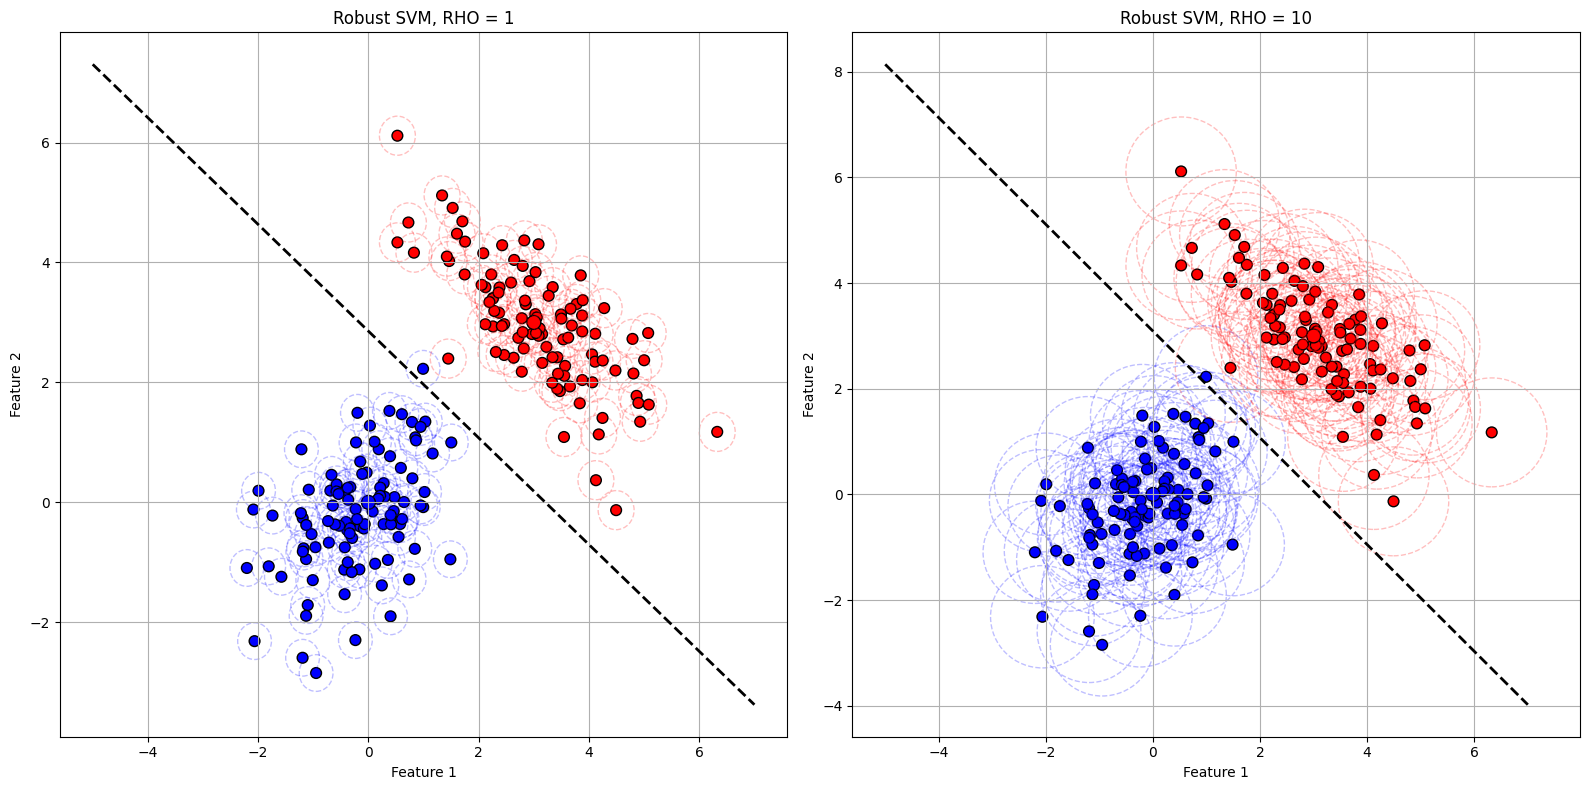

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for i, rho in enumerate(rho_values):
    w_opt, b_opt = solve_svm(lropt.Ellipsoidal(p=P, rho=rho))
    
    df = pd.DataFrame({
        'Feature 1': np.vstack([DATA_1, DATA_2])[:, 0],
        'Feature 2': np.vstack([DATA_1, DATA_2])[:, 1],
        'Class': ['Class 1'] * M + ['Class 2'] * M
    })

    colors = {'Class 1': 'blue', 'Class 2': 'red'}
    x_range = np.linspace(-5, 7, 100)
    y_range = - (w_opt[0] * x_range + b_opt) / w_opt[1]

    mean_df = pd.DataFrame({
        'Feature 1': [MU_1[0], MU_2[0]],
        'Feature 2': [MU_1[1], MU_2[1]],
        'Class': ['Class 1', 'Class 2']
    })

    ax[i].scatter(df['Feature 1'], df['Feature 2'], c=df['Class'].map(colors), label=df['Class'].unique(), s=60, edgecolor='k')
    ax[i].plot(x_range, y_range, color='black', linestyle='--', linewidth=2, label='Decision Boundary')

    ax[i].scatter(mean_df['Feature 1'], mean_df['Feature 2'], c=mean_df['Class'].map(colors), s=100, edgecolor='k', label='Means')
    
    for j in range(len(df)):
        covariance = SIG_1 if df.iloc[j]['Class'] == 'Class 1' else SIG_2
        plot_ellipsoid(ax[i], df.iloc[j][['Feature 1', 'Feature 2']].values, covariance, rho, color=colors[df.iloc[j]['Class']], alpha=0.25)

    ax[i].set_xlabel('Feature 1')
    ax[i].set_ylabel('Feature 2')
    ax[i].set_title(f'Robust SVM, RHO = {rho}')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

## References

1. Ali, A., Kolter, J. Z., Diamond, S., & Boyd, S. (2015). Disciplined convex stochastic programming: A new framework for stochastic optimization. https://web.stanford.edu/~boyd/papers/dcsp.html
